# Setup and Data Import
- This section imports necessary Python libraries for geospatial analysis and sets up project directory paths.
Loads three key datasets:

- Radio station locations
- Buffer zones around stations
- District/subcounty boundaries for Uganda




In [ ]:
# generate grids

import pandas as pd
import numpy as np
import geemap
import folium
import streamlit as st
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point
from colour import Color
from shapely.geometry import box
from shapely.strtree import STRtree
import contextily as ctx

import matplotlib.pyplot as plt
%matplotlib inline



PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'


shapefiles_dir=Path(r"G:\Shared drives\Laterite Projects - Ongoing - UGANDA\Lively Minds\Analysis\Range estimation\Aux_data\shapefiles")

In [2]:
station_loc_gdf = gpd.read_file(PROCESSED_DATA_DIR / 'station_loc.gpkg')
#buffers
buffers_gdf=gpd.read_file(PROCESSED_DATA_DIR / 'station_buffers.gpkg')
#only select the 25 km outer buffer. 

#districts

districts_gdf=gpd.read_file(shapefiles_dir/"uga_admbnda_adm4_ubos_20200824.shp")



# Grid Creation Functions
Defines a function to create a regular grid (fishnet) with specified cell size:

- Uses UTM Zone 36N projection for accurate measurements in Uganda
- Creates uniform grid cells of specified size
- Handles coordinate system transformations
- Assigns unique IDs to grid cells



In [3]:
def create_fishnet_grid(bbox_gdf, cell_size=500, output_crs=None):
    """
    Create a fishnet grid with specified cell size and optional output CRS.
    
    Parameters:
    -----------
    bbox_gdf : GeoDataFrame
        The bounding box as a GeoDataFrame
    cell_size : int
        The cell size in meters (default: 500)
    output_crs : str or pyproj.CRS, optional
        The desired output CRS. If None, returns grid in the same CRS as bbox_gdf
        
    Returns:
    --------
    GeoDataFrame
        Fishnet grid with specified cell size and CRS
    """
    # First convert the bbox to a projected CRS suitable for Uganda
    # UTM Zone 36N (EPSG:32636) is appropriate for Uganda
    bbox_projected = bbox_gdf.to_crs(epsg=32636)
    
    # Get the bounds in meters
    minx, miny, maxx, maxy = bbox_projected.total_bounds
    
    # Generate arrays of x and y coordinates
    x_coords = np.arange(minx, maxx + cell_size, cell_size)
    y_coords = np.arange(miny, maxy + cell_size, cell_size)
    
    # Create empty list to store grid cells
    grid_cells = []
    
    # Create grid cells
    for x in x_coords[:-1]:
        for y in y_coords[:-1]:
            # Create polygon for grid cell
            cell = box(x, y, x + cell_size, y + cell_size)
            grid_cells.append(cell)
    
    # Convert to GeoDataFrame with UTM projection
    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs='EPSG:32636')
    
    # Convert to output CRS if specified, otherwise use bbox_gdf's CRS
    final_crs = output_crs if output_crs is not None else bbox_gdf.crs
    grid_gdf = grid_gdf.to_crs(final_crs)
    
    # Add grid ID
    grid_gdf['grid_id'] = range(len(grid_gdf))
    
    return grid_gdf


## Bounding Box and Study Area Definition
- Creates a bounding box around all buffer zones and filters district data to study area.
- Creates a spatial index for efficient geometric operations on the grid.



In [4]:
# Create bounding box and convert to GeoDataFrame in one step
minx, miny, maxx, maxy = buffers_gdf.total_bounds
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=buffers_gdf.crs)

#the shapefile is at subcounty reduce the districts/subcounty dataframe to the intersection of the outermost buffers. 
lm_districts_subcounty_gdf = districts_gdf[districts_gdf.intersects(bbox)]



# Create fishnet grid using the bbox_gdf
grid_gdf = create_fishnet_grid(bbox_gdf, cell_size=1000, output_crs=lm_districts_subcounty_gdf.crs )

#create a spatial index for faster processing. 

def create_spatial_index(gdf):
    """
    Create a spatial index for faster geometric operations.
    STRtree (Sort-Tile-Recursive) is efficient for spatial queries.
    """
    # Create spatial index from the geometries
    spatial_index = STRtree(gdf.geometry.values)
    return spatial_index

grid_spatial_index = STRtree(grid_gdf.geometry.values)


## create a gridded representation of buffer zones/coverage bands

- Processes buffers from smallest to largest
- Identifies grid cells that intersect with each buffer
- Records buffer properties for each intersecting cell
- Maintains information about multiple buffer distances for overlapping areas



In [5]:
def create_grid_buffer(grid_gdf, grid_spatial_index, buffers_gdf):
    """
    Create a grid representation of radio station buffer zones by identifying which 
    buffer(s) each grid cell overlaps with. Preserves information about all buffer
    distances that cover each cell.

    Parameters
    ----------
    grid_gdf : GeoDataFrame
        A GeoDataFrame containing the fishnet grid cells. Must have 'geometry' column.
    grid_spatial_index : STRtree
        Spatial index created from grid_gdf geometries for efficient spatial queries.
    buffers_gdf : GeoDataFrame
        A GeoDataFrame containing the radio station buffer zones.

    Returns
    -------
    GeoDataFrame
        A GeoDataFrame containing grid cells and their buffer information.
        Each row represents a unique grid cell-buffer combination.
    """
    # Create a list to store all grid cell-buffer combinations
    grid_buffer_records = []
    
    # Sort buffers by distance (ascending) to process smaller buffers first
    sorted_buffers = buffers_gdf.sort_values('buffer_km')
    
    # For each buffer zone in the buffers_gdf
    for idx, buffer in sorted_buffers.iterrows():
        # Use spatial index to find grid cells that potentially intersect with this buffer
        potential_matches_idx = grid_spatial_index.query(buffer.geometry)
        potential_matches = grid_gdf.iloc[potential_matches_idx]
        
        # For each potentially intersecting grid cell
        for grid_idx, grid_cell in potential_matches.iterrows():
            # Check if there's actual intersection
            if grid_cell.geometry.intersects(buffer.geometry):
                # Calculate the proportion of grid cell that intersects with buffer
                intersection_area = grid_cell.geometry.intersection(buffer.geometry).area
                cell_area = grid_cell.geometry.area
                overlap_proportion = intersection_area / cell_area
                
                # If more than 50% of the grid cell intersects with the buffer
                if overlap_proportion > 0.5:
                    grid_buffer_records.append({
                        'grid_id': grid_cell.name,
                        'station_name': buffer.station_name,
                        'buffer_km': buffer.buffer_km,
                        'buffer_color': buffer.buffer_color,
                        'original_color': buffer.original_color,
                        'geometry': grid_cell.geometry,
                        'overlap_proportion': overlap_proportion
                    })
    
    # Convert records to GeoDataFrame
    grid_buffers = gpd.GeoDataFrame(grid_buffer_records, crs=grid_gdf.crs)
    
    return grid_buffers



Generate final gridded buffer representation, creates summary statistics, and exports results to file. ---> 
PROCESSED_DATA_DIR/gridded_buffers_gdf.gpkg


In [6]:
gridded_buffers_gdf = create_grid_buffer(grid_gdf, grid_spatial_index, buffers_gdf)

# Print summary to verify we have all buffer distances
print("Buffer distances by station:")
summary = gridded_buffers_gdf.groupby(['station_name', 'buffer_km']).size().reset_index(name='cell_count')
display(summary)
# export the gridded_buffers_gdf 
gridded_buffers_gdf.to_file(PROCESSED_DATA_DIR / 'gridded_buffers_gdf.gpkg')


Buffer distances by station:


,station_name,buffer_km,cell_count
0,Aisa FM,20.0,1263
1,Aisa FM,25.0,1971
2,Aisa FM,40.0,5024
3,Aisa FM,60.0,11295
4,Dokolo FM,20.0,1250
5,Dokolo FM,25.0,1954
6,Dokolo FM,40.0,5007
7,Dokolo FM,60.0,11293
8,Dwanwana FM,20.0,1254
9,Dwanwana FM,25.0,1959


# visualisations

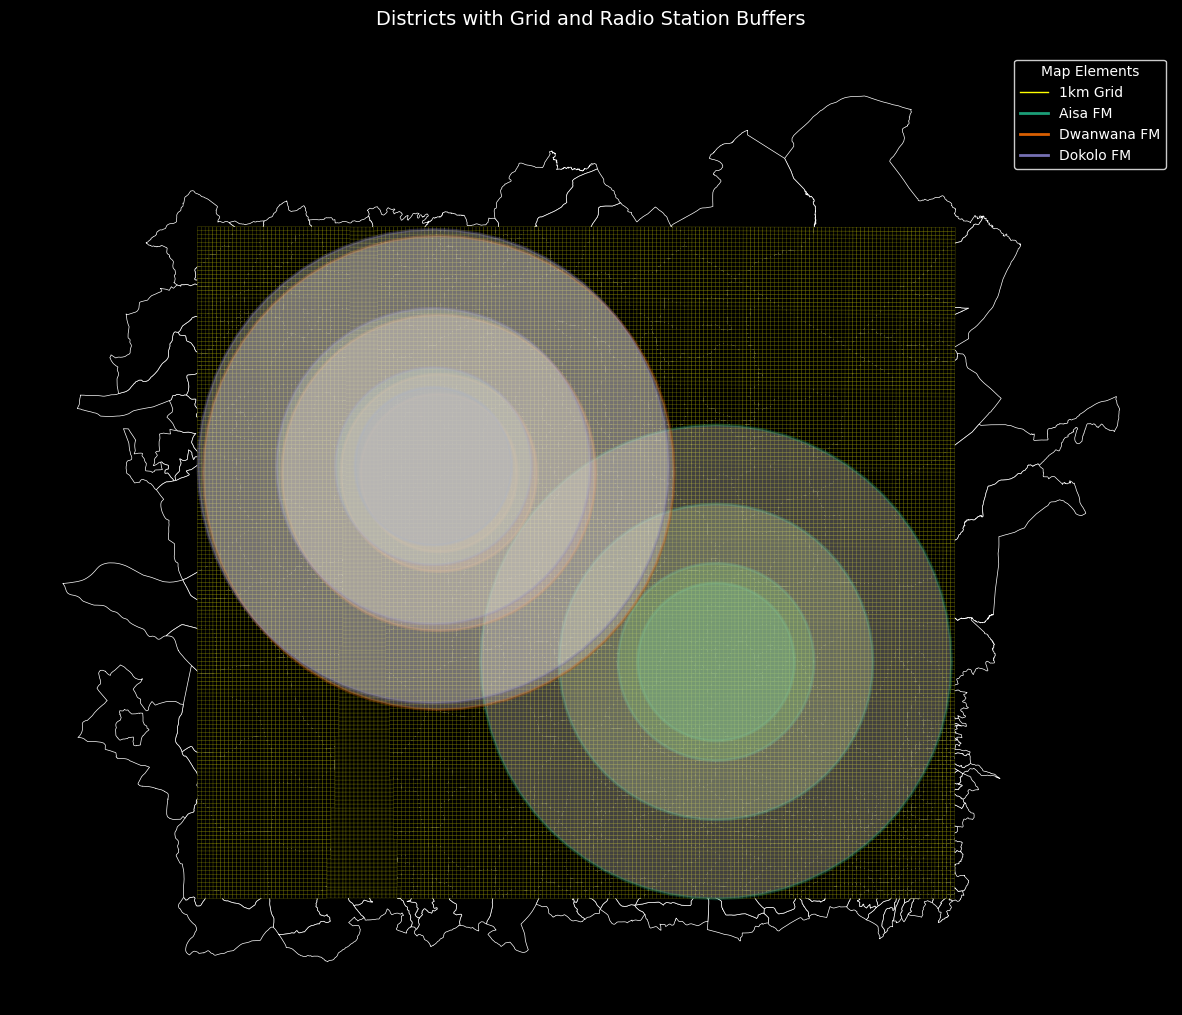

Number of subcounties: 346
Number of grid cells: 32810
Number of buffer zones: 12


In [7]:
def plot_all_layers(districts_gdf, grid_gdf, buffers_gdf, figsize=(15, 15)):
    # Create figure and axis with black background
    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    
    # 1. Plot districts with black fill and white edges
    districts_gdf.plot(ax=ax,
                      color='black',
                      edgecolor='white',
                      linewidth=0.5)
    
    # 2. Plot grid overlay in yellow
    grid_gdf.plot(ax=ax,
                  color='black',
                  edgecolor='yellow',
                  linewidth=0.1,
                  alpha=1)
    
    # 3. Plot buffer zones with thicker lines and less transparency
    for idx, buffer in buffers_gdf.iterrows():
        buffer_geom = gpd.GeoDataFrame(geometry=[buffer.geometry])
        buffer_geom.plot(ax=ax,
                        color=buffer['buffer_color'],
                        alpha=0.3,  
                        edgecolor=buffer['original_color'],
                        linewidth=2.0)  # Thicker lines
    
    # Customize the plot
    ax.set_title('Districts with Grid and Radio Station Buffers', 
                fontsize=14, 
                pad=20, 
                color='white')  # White title
    ax.axis('off')
    ax.set_aspect('equal')
    
    # Create custom legend including grid
    legend_elements = [
        # Add grid line to legend
        plt.Line2D([0], [0], 
                   color='yellow', 
                   linewidth=1, 
                   label='1km Grid')
    ]
    
    # Add radio stations to legend
    unique_stations = buffers_gdf['station_name'].unique()
    for station in unique_stations:
        station_color = buffers_gdf[buffers_gdf['station_name'] == station]['original_color'].iloc[0]
        legend_elements.append(
            plt.Line2D([0], [0], 
                      color=station_color,
                      linewidth=2,
                      label=station)
        )
    
    # Add legend with white text
    legend = ax.legend(handles=legend_elements, 
                      loc='upper right',
                      title='Map Elements',
                      frameon=True)
    
    # Style legend
    legend.get_frame().set_facecolor('black')
    legend.get_frame().set_edgecolor('white')
    plt.setp(legend.get_texts(), color='white')
    plt.setp(legend.get_title(), color='white')
    
    return fig, ax

# Create the plot
fig, ax = plot_all_layers(lm_districts_subcounty_gdf, grid_gdf, buffers_gdf)

# Display the figure
display(fig)
plt.close(fig)

# Print some information about the layers
print(f"Number of subcounties: {len(lm_districts_subcounty_gdf)}")
print(f"Number of grid cells: {len(grid_gdf)}")
print(f"Number of buffer zones: {len(buffers_gdf)}")


In [8]:
def plot_single_station_buffers(grid_buffer_representation, station_name, ax=None, figsize=(15, 15)):
    """
    Plot all buffer zones for a selected radio station, keeping overlapping cells.
    
    Parameters
    ----------
    grid_buffer_representation : GeoDataFrame
        Output from create_grid_buffer_representation function
    station_name : str
        Name of the radio station to plot
    figsize : tuple
        Figure size for the plot
    """
    # Create figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    
    # Filter data for selected station
    station_data = grid_buffer_representation[grid_buffer_representation['station_name'] == station_name].copy()
    
    if station_data.empty:
        raise ValueError(f"No data found for station: {station_name}")
    
    # Get buffer distances in descending order (plot largest first)
    buffer_distances = sorted(station_data['buffer_km'].unique(), reverse=True)
    
    # Create legend handles and labels
    legend_handles = []
    legend_labels = []
    
    # Plot each buffer zone from largest to smallest
    for buffer_km in buffer_distances:
        # Get cells for this buffer distance
        buffer_cells = station_data[station_data['buffer_km'] == buffer_km]
        
        # Create GeoDataFrame for this buffer
        buffer_gdf = gpd.GeoDataFrame(buffer_cells, geometry='geometry', crs=grid_buffer_representation.crs)
        
        # Plot the cells
        buffer_gdf.plot(ax=ax,
                       color=buffer_cells['buffer_color'].iloc[0],
                       edgecolor='white',
                       linewidth=0.1,
                       alpha=0.7)
        
        # Create legend entry
        legend_handles.append(plt.Rectangle((0,0), 1, 1, 
                                         fc=buffer_cells['buffer_color'].iloc[0],
                                         alpha=0.7))
        legend_labels.append(f"{buffer_km}km")
    
    # Customize the plot
    ax.set_title(f'Coverage Areas - {station_name}', 
                fontsize=14, 
                pad=20)
    
    # Add legend
    ax.legend(legend_handles, 
             legend_labels,
             title='Buffer Distances',
             loc='upper right')
    
    # Remove axes
    ax.set_axis_off()
    
    return ax



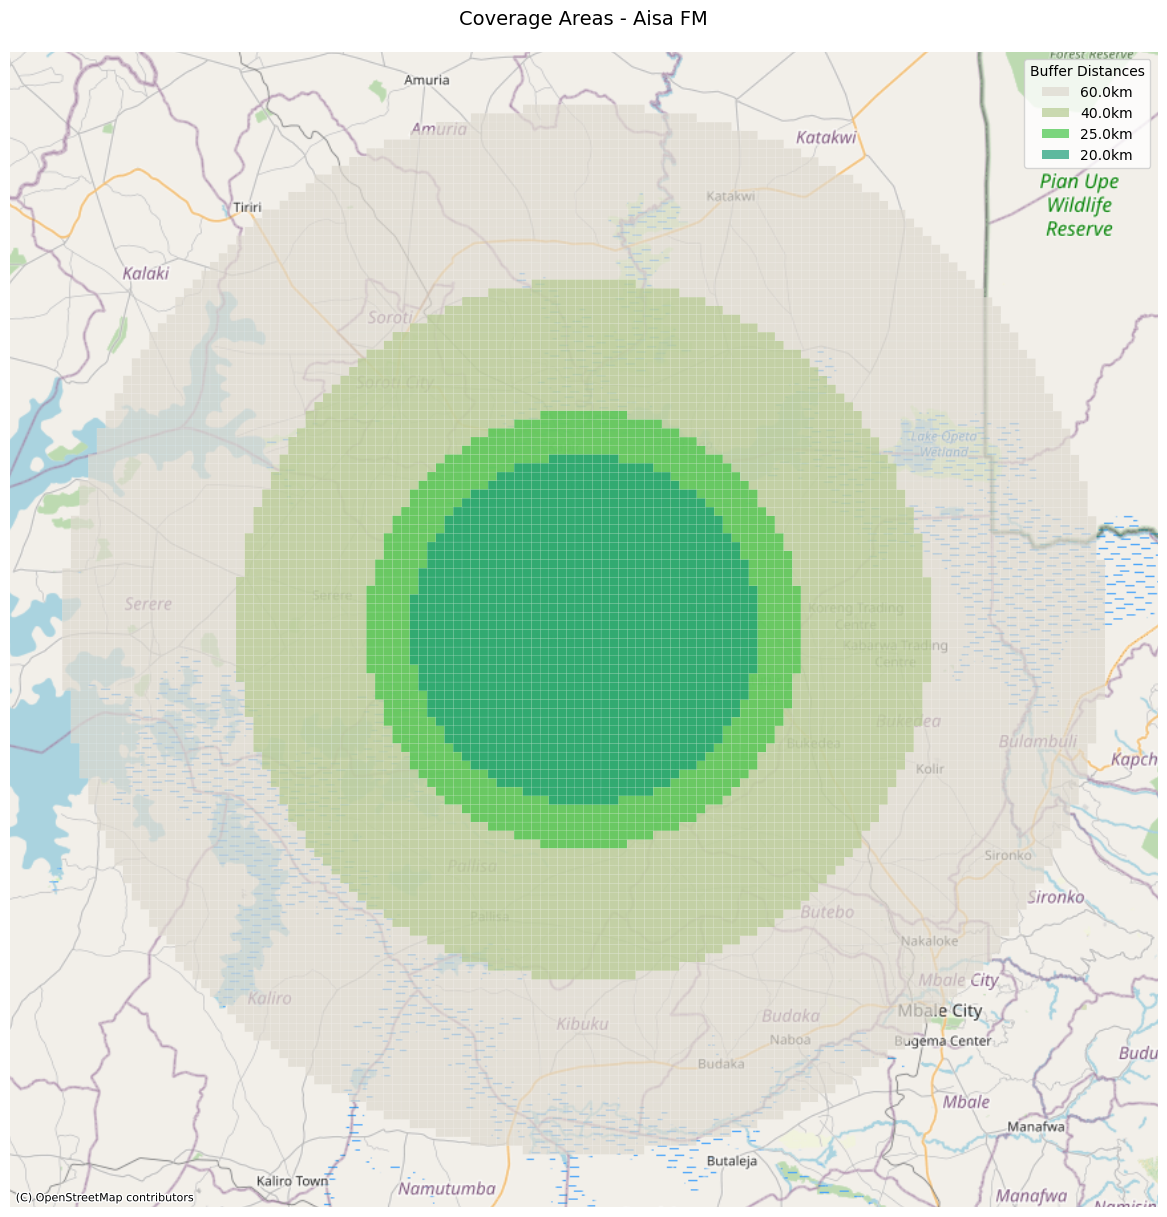

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot station buffers on the same axis
station = "Aisa FM"
plot_single_station_buffers(gridded_buffers_gdf.to_crs(epsg=3857), station, ax=ax)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

display(fig)
plt.close(fig)


In [ ]:
#slightly different visualisation. 
def plot_single_station_buffers(grid_buffer_representation, station_name, ax=None, figsize=(15, 15)):
    """
    Plot all buffer zones for a selected radio station, using colored edges instead of fills.
    
    Parameters
    ----------
    grid_buffer_representation : GeoDataFrame
        Output from create_grid_buffer_representation function
    station_name : str
        Name of the radio station to plot
    ax : matplotlib.axes, optional
        Axis to plot on. If None, creates new figure and axis
    figsize : tuple
        Figure size for the plot if creating new figure
    """
    # Create figure and axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Filter data for selected station
    station_data = grid_buffer_representation[grid_buffer_representation['station_name'] == station_name].copy()
    
    if station_data.empty:
        raise ValueError(f"No data found for station: {station_name}")
    
    # Get buffer distances in descending order (plot largest first)
    buffer_distances = sorted(station_data['buffer_km'].unique(), reverse=True)
    
    # Create legend handles and labels
    legend_handles = []
    legend_labels = []
    
    # Plot each buffer zone from largest to smallest
    for buffer_km in buffer_distances:
        # Get cells for this buffer distance
        buffer_cells = station_data[station_data['buffer_km'] == buffer_km]
        
        # Create GeoDataFrame for this buffer
        buffer_gdf = gpd.GeoDataFrame(buffer_cells, geometry='geometry', crs=grid_buffer_representation.crs)
        
        # Plot the cells with no fill but colored edges
        buffer_gdf.plot(ax=ax,
                       color='none',  # No fill
                       edgecolor=buffer_cells['buffer_color'].iloc[0],  # Use buffer color for edges
                       linewidth=0.5,  # Thicker lines
                       alpha=1.0)  # Full opacity for edges
        
        # Create legend entry
        legend_handles.append(plt.Line2D([0], [0], 
                                       color=buffer_cells['buffer_color'].iloc[0],
                                       linewidth=2))
        legend_labels.append(f"{buffer_km}km")
    
    # Customize the plot
    ax.set_title(f'Coverage Areas - {station_name}', 
                fontsize=14, 
                pad=20)
    
    # Add legend
    ax.legend(legend_handles, 
             legend_labels,
             title='Buffer Distances',
             loc='upper right')
    
    # Remove axes
    ax.set_axis_off()
    
    return ax


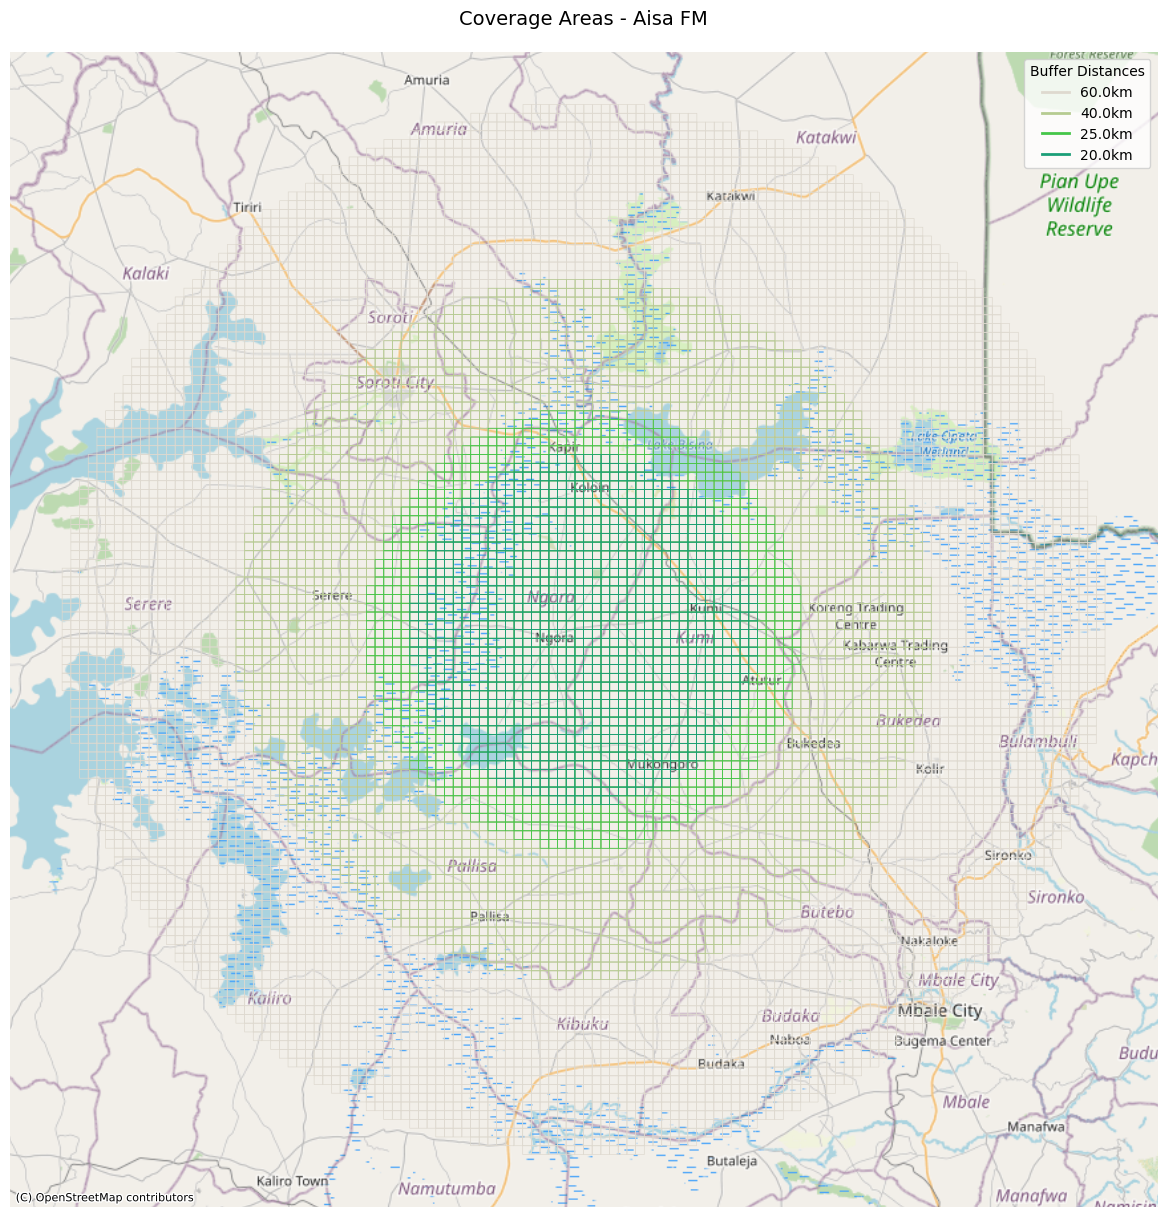

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot station buffers on the same axis
station = "Aisa FM"
plot_single_station_buffers(gridded_buffers_gdf.to_crs(epsg=3857), station, ax=ax)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

display(fig)
plt.close(fig)
